# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input/R5KrjnANiKVhLWAkpXhNBe'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

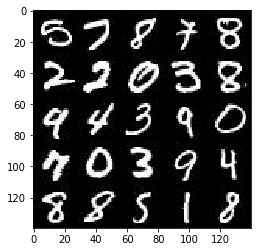

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

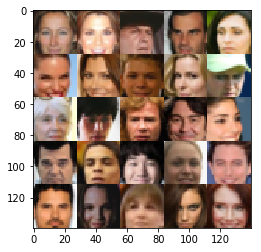

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width  --> 28
    :param image_height: The input image height --> 28
    :param image_channels: The number of image channels --> 3
    :param z_dim: The dimension of Z --> 100
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    tensor_real_imput_img = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    tensor_z_data = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return (tensor_real_imput_img, tensor_z_data, learning_rate)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)--> Tensor("Placeholder:0", shape=(?, 28, 28, 3), dtype=float32)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer --> 28, 28, 3
        start_dim = 32
        kernel_sz = 5
        alpha = 0.2
        strides = 2
        
        layer_0 = tf.layers.conv2d(images, start_dim, kernel_sz, strides=strides, padding='same')
        relu_0 = tf.maximum(alpha * layer_0, layer_0)
        #0 --> ?, 10, 10, 64
        #14*14*64
        
        layer_1 = tf.layers.conv2d(layer_0, start_dim*2, kernel_sz, strides=strides, padding='same')
        batchnorm_1 = tf.layers.batch_normalization(layer_1, training=True)
        relu_1 = tf.maximum(alpha * layer_1, layer_1)
        #  7, 7, 128
        
        layer_2 = tf.layers.conv2d(layer_1, start_dim*4, kernel_sz, strides=strides, padding='same')
        batchnorm_2 = tf.layers.batch_normalization(layer_2, training=True)
        relu_2 = tf.maximum(alpha * layer_2, layer_2)
        #4, 4, 256
        
        flatten = tf.reshape(relu_2, (-1, (4*4*(start_dim*4)))) # --> (?, 2048)
        
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)

    return (output, logits)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z --> Tensor("Placeholder:0", shape=(?, 100), dtype=float32)
    :param out_channel_dim: The number of channels in the output image --> 5
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        start_dim = 512
        kernel_sz = 5
        alpha = 0.2
        strides = 2
        #100
        layer_0 = tf.layers.dense(z, 7*7*start_dim)
    
        layer_0 = tf.reshape(layer_0, (-1, 7, 7, start_dim))
        layer_0 = tf.layers.batch_normalization(layer_0, training=is_train)
        # 7, 7, 512 
      
        layer_1 = tf.layers.conv2d_transpose(layer_0, int(start_dim/2), kernel_sz, strides=strides, padding='same')
        layer_1 = tf.layers.batch_normalization(layer_1, training=is_train)
        relu_1 = tf.maximum(alpha * layer_1, layer_1)
        # 14, 14, 256
    
        layer_2 = tf.layers.conv2d_transpose(layer_1, int(start_dim/4), kernel_sz, strides=strides, padding='same')
        layer_2 = tf.layers.batch_normalization(layer_2, training=is_train)
        relu_2 = tf. maximum(alpha * layer_2, layer_2)
        # 28, 28, 128
    
        logits = tf.layers.conv2d_transpose(layer_2, out_channel_dim, kernel_sz, strides=strides, padding='same')
        logits = tf.reshape(logits, (-1, 28, 28, out_channel_dim))
        output = tf.tanh(logits)
        # 28,28,5
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    #generator with z input
    g_mod = generator(input_z, out_channel_dim)
    
    # discriminator with real input and g_mod output
    d_out_real, d_log_real = discriminator(input_real)
    d_out_fake, d_log_fake = discriminator(g_mod, reuse=True)
    
    d_loss_real = tf.reduce_mean(
                                tf.nn.sigmoid_cross_entropy_with_logits(
                                    logits=d_log_real,
                                    labels=tf.ones_like(d_log_real) * (1 - smooth)
                                 ))
    
    d_loss_fake = tf.reduce_mean(
                                tf.nn.sigmoid_cross_entropy_with_logits(
                                logits=d_log_fake,
                                labels=tf.zeros_like(d_log_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_log_fake,
                                                                 labels=tf.ones_like(d_log_fake)))
    
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer --> 0.9 (eg less than 1)
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    
    #variable generators with shape (3,3), float32
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    
    d_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_op = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)

    return (d_train_op, g_train_op)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches,
          data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension --> 100
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data  --> (60000, 28, 28, 1)
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    div_by = 20
    n_images = 10
    image_mode="RGB"
    samples=[]
    
    input_real, input_z, lr = model_inputs(data_shape[1], 
                                                      data_shape[2], 
                                                      data_shape[3], 
                                                      z_dim)
    # --> Tensor("Placeholder:0", shape=(?, 28, 28, 1), dtype=float32) 
    # Tensor("Placeholder_1:0", shape=(?, 100), dtype=float32)
    # Tensor("Placeholder_2:0", dtype=float32)
            
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    # --> Tensor("add:0", shape=(), dtype=float32), Tensor("Mean_2:0", shape=(), dtype=float32) 
    
    d_train_op, g_train_op = model_opt(d_loss, g_loss, learning_rate, beta1)
     

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # sample random noise
                z_batch = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # engage optimizers for discriminator and generator
                _ = sess.run(d_train_op, feed_dict={input_real: batch_images,
                                                    input_z: z_batch, 
                                                    lr:learning_rate})
                _ = sess.run(g_train_op, feed_dict={input_real: batch_images,
                                                    input_z: z_batch,
                                                    lr: learning_rate})
        
                batch_images = batch_images * 2
            
                # get losses for printing every n steps
                if steps % 20 == 0:
                    d_train_loss = d_loss.eval({input_real: batch_images, input_z: z_batch})
                    g_train_loss = g_loss.eval({input_z: z_batch})

                    print("Epoch {}/{} {} steps".format(epoch_i+1, epochs, steps), 
                         "- training losses: "
                         " discriminator: {:.4f}".format(d_train_loss),
                         "| generator {:.4f}".format(g_train_loss))
                    
                    if steps % 100 == 0:
                        if data_shape[3] == 1:
                            image_mode= "L"
                        show_generator_output(sess, n_images, input_z, data_shape[3], image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 20 steps - training losses:  discriminator: 1.1083 | generator 1.2544
Epoch 1/2 40 steps - training losses:  discriminator: 0.8350 | generator 1.6224
Epoch 1/2 60 steps - training losses:  discriminator: 0.8703 | generator 1.4456
Epoch 1/2 80 steps - training losses:  discriminator: 1.4448 | generator 1.3110
Epoch 1/2 100 steps - training losses:  discriminator: 1.6493 | generator 2.0446


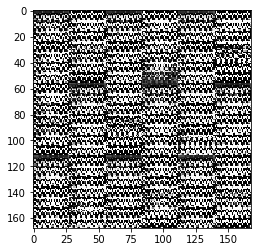

Epoch 1/2 120 steps - training losses:  discriminator: 1.9790 | generator 0.5805
Epoch 1/2 140 steps - training losses:  discriminator: 1.6616 | generator 2.2546
Epoch 1/2 160 steps - training losses:  discriminator: 1.2560 | generator 1.4518
Epoch 1/2 180 steps - training losses:  discriminator: 1.5193 | generator 1.5475
Epoch 1/2 200 steps - training losses:  discriminator: 1.9239 | generator 1.2424


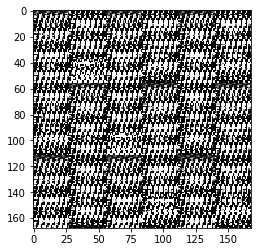

Epoch 1/2 220 steps - training losses:  discriminator: 1.6429 | generator 1.1861
Epoch 1/2 240 steps - training losses:  discriminator: 1.2773 | generator 1.2581
Epoch 1/2 260 steps - training losses:  discriminator: 1.1362 | generator 1.2274
Epoch 1/2 280 steps - training losses:  discriminator: 0.8632 | generator 1.7696
Epoch 1/2 300 steps - training losses:  discriminator: 0.9304 | generator 1.3363


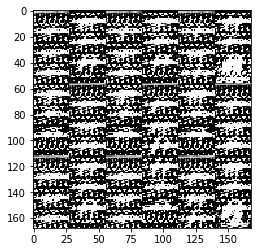

Epoch 1/2 320 steps - training losses:  discriminator: 1.0145 | generator 1.3778
Epoch 1/2 340 steps - training losses:  discriminator: 1.0912 | generator 1.3546
Epoch 1/2 360 steps - training losses:  discriminator: 1.0258 | generator 1.2674
Epoch 1/2 380 steps - training losses:  discriminator: 2.9685 | generator 1.0494
Epoch 1/2 400 steps - training losses:  discriminator: 0.9961 | generator 1.0342


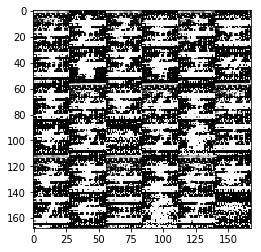

Epoch 1/2 420 steps - training losses:  discriminator: 1.4796 | generator 1.5979
Epoch 1/2 440 steps - training losses:  discriminator: 1.8103 | generator 1.1542
Epoch 1/2 460 steps - training losses:  discriminator: 1.3048 | generator 1.2943
Epoch 2/2 480 steps - training losses:  discriminator: 1.5091 | generator 2.0309
Epoch 2/2 500 steps - training losses:  discriminator: 1.9024 | generator 1.4615


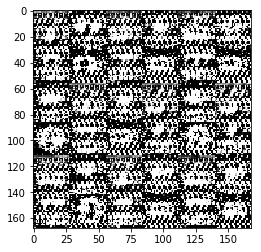

Epoch 2/2 520 steps - training losses:  discriminator: 1.4813 | generator 1.8146
Epoch 2/2 540 steps - training losses:  discriminator: 1.0565 | generator 2.2187
Epoch 2/2 560 steps - training losses:  discriminator: 1.5596 | generator 2.2984
Epoch 2/2 580 steps - training losses:  discriminator: 0.9593 | generator 1.3104
Epoch 2/2 600 steps - training losses:  discriminator: 0.9658 | generator 1.4556


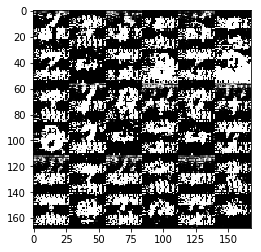

Epoch 2/2 620 steps - training losses:  discriminator: 0.9793 | generator 1.7856
Epoch 2/2 640 steps - training losses:  discriminator: 1.0145 | generator 3.0717
Epoch 2/2 660 steps - training losses:  discriminator: 1.0282 | generator 1.7308
Epoch 2/2 680 steps - training losses:  discriminator: 1.8035 | generator 1.6650
Epoch 2/2 700 steps - training losses:  discriminator: 1.4884 | generator 2.2645


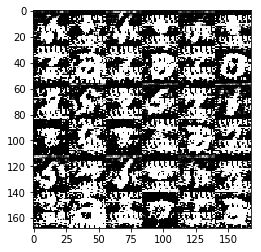

Epoch 2/2 720 steps - training losses:  discriminator: 2.4619 | generator 2.4345
Epoch 2/2 740 steps - training losses:  discriminator: 2.1958 | generator 2.4102
Epoch 2/2 760 steps - training losses:  discriminator: 4.5146 | generator 2.9200
Epoch 2/2 780 steps - training losses:  discriminator: 10.9413 | generator 4.4072
Epoch 2/2 800 steps - training losses:  discriminator: 1.0847 | generator 1.5728


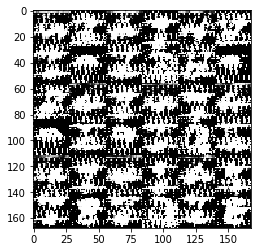

Epoch 2/2 820 steps - training losses:  discriminator: 1.8948 | generator 2.4526
Epoch 2/2 840 steps - training losses:  discriminator: 2.0892 | generator 1.9500
Epoch 2/2 860 steps - training losses:  discriminator: 1.3675 | generator 2.5111
Epoch 2/2 880 steps - training losses:  discriminator: 3.1370 | generator 2.6394
Epoch 2/2 900 steps - training losses:  discriminator: 2.5741 | generator 1.8372


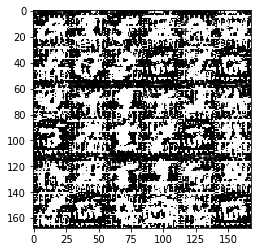

Epoch 2/2 920 steps - training losses:  discriminator: 3.1408 | generator 1.9785


In [ ]:
batch_size = 128
z_dim = 75
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 20 steps - training losses:  discriminator: 1.1858 | generator 1.0908
Epoch 1/1 40 steps - training losses:  discriminator: 0.9194 | generator 1.3375
Epoch 1/1 60 steps - training losses:  discriminator: 0.8604 | generator 1.3818
Epoch 1/1 80 steps - training losses:  discriminator: 0.6904 | generator 2.8582
Epoch 1/1 100 steps - training losses:  discriminator: 2.1285 | generator 1.0176


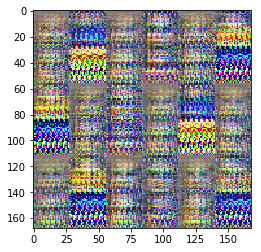

Epoch 1/1 120 steps - training losses:  discriminator: 0.6724 | generator 2.2294
Epoch 1/1 140 steps - training losses:  discriminator: 0.6589 | generator 2.8619
Epoch 1/1 160 steps - training losses:  discriminator: 0.6868 | generator 2.6479
Epoch 1/1 180 steps - training losses:  discriminator: 3.4073 | generator 0.2691
Epoch 1/1 200 steps - training losses:  discriminator: 0.8152 | generator 1.9272


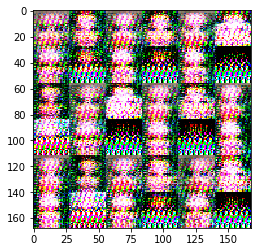

Epoch 1/1 220 steps - training losses:  discriminator: 0.6231 | generator 2.4425
Epoch 1/1 240 steps - training losses:  discriminator: 0.6825 | generator 2.5286
Epoch 1/1 260 steps - training losses:  discriminator: 0.6450 | generator 2.7978
Epoch 1/1 280 steps - training losses:  discriminator: 0.6982 | generator 3.0073
Epoch 1/1 300 steps - training losses:  discriminator: 0.8043 | generator 2.8997


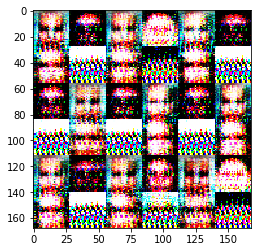

Epoch 1/1 320 steps - training losses:  discriminator: 0.9118 | generator 2.6972
Epoch 1/1 340 steps - training losses:  discriminator: 0.8990 | generator 2.7421
Epoch 1/1 360 steps - training losses:  discriminator: 0.6645 | generator 3.5728
Epoch 1/1 380 steps - training losses:  discriminator: 0.6748 | generator 2.6220
Epoch 1/1 400 steps - training losses:  discriminator: 0.6975 | generator 3.5146


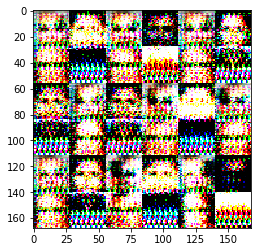

Epoch 1/1 420 steps - training losses:  discriminator: 0.6603 | generator 3.4182
Epoch 1/1 440 steps - training losses:  discriminator: 0.6146 | generator 5.0031
Epoch 1/1 460 steps - training losses:  discriminator: 0.6646 | generator 4.7861
Epoch 1/1 480 steps - training losses:  discriminator: 0.6193 | generator 5.9410
Epoch 1/1 500 steps - training losses:  discriminator: 0.6316 | generator 3.5266


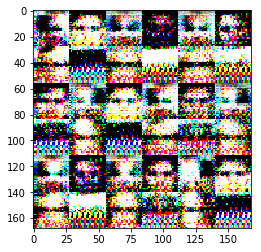

Epoch 1/1 520 steps - training losses:  discriminator: 0.6652 | generator 4.6010
Epoch 1/1 540 steps - training losses:  discriminator: 0.6137 | generator 4.7899
Epoch 1/1 560 steps - training losses:  discriminator: 0.5431 | generator 4.4059
Epoch 1/1 580 steps - training losses:  discriminator: 0.7452 | generator 6.2773
Epoch 1/1 600 steps - training losses:  discriminator: 0.9679 | generator 2.3642


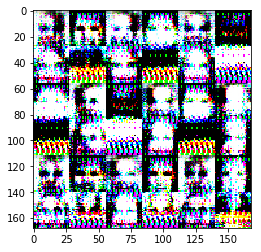

Epoch 1/1 620 steps - training losses:  discriminator: 0.8583 | generator 2.1017
Epoch 1/1 640 steps - training losses:  discriminator: 0.7494 | generator 2.4739
Epoch 1/1 660 steps - training losses:  discriminator: 0.7200 | generator 3.4205
Epoch 1/1 680 steps - training losses:  discriminator: 0.7452 | generator 5.2650
Epoch 1/1 700 steps - training losses:  discriminator: 0.6449 | generator 2.8767


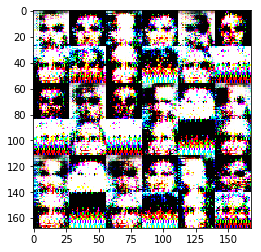

Epoch 1/1 720 steps - training losses:  discriminator: 0.5447 | generator 6.4145
Epoch 1/1 740 steps - training losses:  discriminator: 0.6316 | generator 3.6477
Epoch 1/1 760 steps - training losses:  discriminator: 0.6150 | generator 4.7098
Epoch 1/1 780 steps - training losses:  discriminator: 0.6803 | generator 3.3875
Epoch 1/1 800 steps - training losses:  discriminator: 0.6164 | generator 4.7928


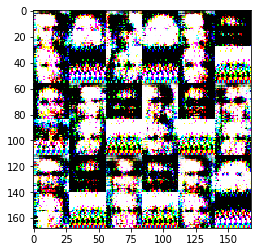

Epoch 1/1 820 steps - training losses:  discriminator: 0.6710 | generator 3.9503
Epoch 1/1 840 steps - training losses:  discriminator: 0.6487 | generator 4.0595
Epoch 1/1 860 steps - training losses:  discriminator: 0.7197 | generator 4.3209
Epoch 1/1 880 steps - training losses:  discriminator: 0.7301 | generator 3.1682
Epoch 1/1 900 steps - training losses:  discriminator: 1.0729 | generator 2.7223


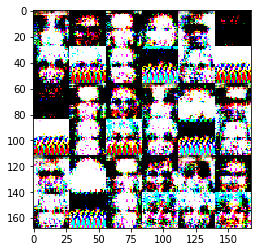

Epoch 1/1 920 steps - training losses:  discriminator: 0.6117 | generator 5.3318
Epoch 1/1 940 steps - training losses:  discriminator: 0.8315 | generator 4.1903
Epoch 1/1 960 steps - training losses:  discriminator: 3.9772 | generator 4.7566
Epoch 1/1 980 steps - training losses:  discriminator: 0.8417 | generator 2.6042
Epoch 1/1 1000 steps - training losses:  discriminator: 0.7732 | generator 2.3903


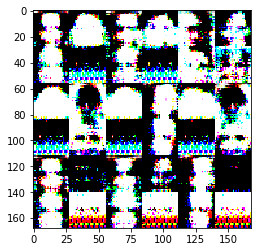

Epoch 1/1 1020 steps - training losses:  discriminator: 0.7738 | generator 2.8935
Epoch 1/1 1040 steps - training losses:  discriminator: 0.6856 | generator 2.7702
Epoch 1/1 1060 steps - training losses:  discriminator: 0.5875 | generator 7.2389
Epoch 1/1 1080 steps - training losses:  discriminator: 0.6764 | generator 5.0783
Epoch 1/1 1100 steps - training losses:  discriminator: 0.5908 | generator 5.6021


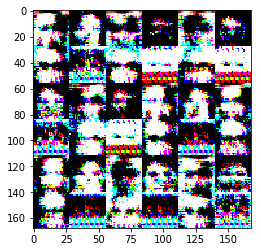

Epoch 1/1 1120 steps - training losses:  discriminator: 0.6766 | generator 11.5368
Epoch 1/1 1140 steps - training losses:  discriminator: 0.6909 | generator 5.2041
Epoch 1/1 1160 steps - training losses:  discriminator: 0.5918 | generator 5.0234
Epoch 1/1 1180 steps - training losses:  discriminator: 0.6082 | generator 8.2202
Epoch 1/1 1200 steps - training losses:  discriminator: 0.7191 | generator 3.3978


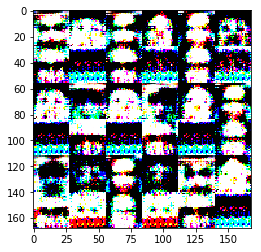

Epoch 1/1 1220 steps - training losses:  discriminator: 0.6261 | generator 7.1661
Epoch 1/1 1240 steps - training losses:  discriminator: 0.6320 | generator 4.6355
Epoch 1/1 1260 steps - training losses:  discriminator: 0.5814 | generator 4.5761
Epoch 1/1 1280 steps - training losses:  discriminator: 0.6820 | generator 4.6589
Epoch 1/1 1300 steps - training losses:  discriminator: 0.7003 | generator 4.3999


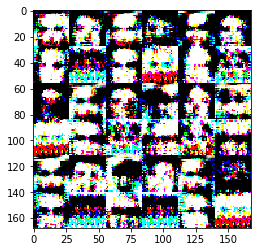

Epoch 1/1 1320 steps - training losses:  discriminator: 0.6924 | generator 6.4005
Epoch 1/1 1340 steps - training losses:  discriminator: 0.5666 | generator 6.3130
Epoch 1/1 1360 steps - training losses:  discriminator: 0.6555 | generator 6.6236
Epoch 1/1 1380 steps - training losses:  discriminator: 0.7105 | generator 5.1425
Epoch 1/1 1400 steps - training losses:  discriminator: 0.6660 | generator 3.6590


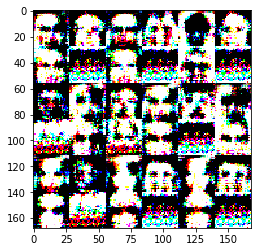

Epoch 1/1 1420 steps - training losses:  discriminator: 0.6399 | generator 4.8658


In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.